In [59]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime as dt
import numpy as np
import netCDF4
import pandas as pd


pdt = dt.datetime(2012,8,1,0)
station = 4
freefile = '/Users/teruhisa/Dropbox/Data/OB500_fennelP/NL/ob500_sta.nc'
obsfile = '/Users/teruhisa/Dropbox/Data/ob500_obs_2012_obweb-1.nc'
pngfile = '/Users/teruhisa/Dropbox/Data/OB500_fennelP/NL/profiles_{}_{}.png'

12 temp /Users/teruhisa/Dropbox/Data/OB500_fennelP/NL/ob500_sta.nc
12 temp /Users/teruhisa/Dropbox/Data/ob500_obs_2012_obweb-1.nc


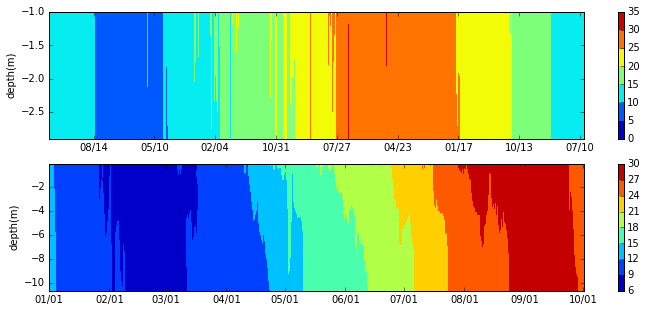

In [76]:

sec_JST = 'seconds since 1968-05-23 09:00:00 GMT'
hour_JST = 'hours since 1968-05-23 09:00:00 GMT'


def staparser(ncfile, station, varname):

    print station, varname, ncfile
    s = station-1

    nc = netCDF4.Dataset(ncfile, 'r')
    kmax = len(nc.dimensions['s_rho'])
    h = nc.variables['h'][s]
    Cs_r = nc.variables['Cs_r'][:]
    
    time = nc.variables['ocean_time'][:]
    time = netCDF4.num2date(time, sec_JST)
    tmax = len(time)
    
    zeta = nc.variables['zeta'][:,s]
    var = nc.variables[varname][:,s,:]
    nc.close()

    depth = np.ndarray(shape=[tmax, kmax])
    for t in xrange(tmax):
        for k in range(kmax):
            depth[t, k] = (h+zeta[t]) * Cs_r[k]
    
    return time, depth[0,:], var.T
    

def obsparser(ncfile, station, varname):

    print station, varname, ncfile
    s = station-1
    types = {'temp':6, 'salt':7, 'chlorophyll': 10, 'oxygen':15}

    nc = netCDF4.Dataset(ncfile, 'r')
    type = nc.variables['obs_type'][:]
    station = nc.variables['obs_station'][:]
    
    index = np.where((type==types[varname]) & (station==s))
    
    time = nc.variables['obs_time'][index]
    depth = nc.variables['obs_depth'][index]
    value = nc.variables['obs_value'][index]
    nc.close()
    
    data = {'time':time, 'depth':depth, 'value':value}
    df = pd.DataFrame(data)
    pv = df.pivot(index='time', columns='depth', values='value')
    
    return pv.index, pv.columns, pv.values.T
    

varname = 'temp'
station = 12
ftime, fdepth, fvalue = staparser(freefile, station, varname)
otime, odepth, ovalue = obsparser(obsfile, station, varname)

fig, ax = plt.subplots(2, 1, figsize=[12,5])

obs = ax[0].contourf(otime, odepth, ovalue) 
free = ax[1].contourf(ftime, fdepth, fvalue) 
cb = plt.colorbar(obs, ax=ax[0])
cb = plt.colorbar(free, ax=ax[1])

for i in range(2):
    #ax[i].set_xlim(dt.datetime(2012,1,1,0), dt.datetime(2012, 10,1,0))
    #ax[i].set_ylim()
    ax[i].xaxis.set_major_formatter( DateFormatter('%m/%d') )
    ax[i].set_ylabel('depth(m)')
    #cb.set_label(cblabel)